<a href="https://colab.research.google.com/github/LuigiElo/DL-PINNs/blob/main/main_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Initial version

In [1]:
!pip install datasets
!pip install transformers
!pip install deepxde

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 48.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 97.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 75.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 35.7 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.19.0
    Uninstalling huggingface-hub-0.19.0:
      Successfully uninstalled huggingface-hub-0.19.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.2/166.2 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 12.5 MB/s eta 0

##Using  neural networks to function approximation




In [156]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

In [176]:
# Define a simple neural network class
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

In [183]:
# Define a function to generate both training and test data
def generate_data(function_type,num_samples=100, test_ratio=0.5):
    # Generate random 1D data
    X = 100* (2 * torch.rand(num_samples, 1) - 1)

    #print(f'Generated data: {X}')

    # Example cubic function for training data
    if function_type == 'cubic':
        Y = 2 * X**3 + 3 * X**2 + 1
    elif function_type == 'sin':
        Y = torch.sin(X)
    elif function_type == 'exp_sin':
        Y = torch.exp(torch.sin(X))
    elif function_type == 'abs':
        Y = torch.abs(X)
    else:
        raise ValueError(f'Invalid function_type: {function_type}')
    # Split the data into training and test sets
    num_test_samples = int(num_samples * test_ratio)
    test_indices = torch.randperm(num_samples)[:num_test_samples]

    test_X = X[test_indices]
    test_Y = Y[test_indices]

    train_X = torch.cat((X[:test_indices[0]], X[test_indices[-1]+1:]))
    train_Y = torch.cat((Y[:test_indices[0]], Y[test_indices[-1]+1:]))

    return (train_X, train_Y), (test_X, test_Y)

# Function to generate 2D data for different functions
def generate_data_2d(function_type, num_samples=100, test_ratio=0.2):
    # Generate random 2D data
    X = 2 * torch.rand(num_samples, 2) - 1

    if function_type == 'cubic':
        Y = 2 * X[:, 0]**3 + 3 * X[:, 1]**2 + 1
    elif function_type == 'sin':
        Y = torch.sin(X[:, 0] + X[:, 1])
    elif function_type == 'exp_sin':
        Y = torch.exp(torch.sin(X[:, 0]) + torch.sin(X[:, 1]))
    elif function_type == 'abs':
        Y = torch.abs(X[:, 0]) + torch.abs(X[:, 1])
    else:
        raise ValueError(f'Invalid function_type: {function_type}')

    # Split the data into training and test sets
    num_test_samples = int(num_samples * test_ratio)
    test_indices = torch.randperm(num_samples)[:num_test_samples]

    test_X = X[test_indices]
    test_Y = Y[test_indices]

    train_X = torch.cat((X[:test_indices[0]], X[test_indices[-1]+1:]))
    train_Y = torch.cat((Y[:test_indices[0]], Y[test_indices[-1]+1:]))

    return (train_X, train_Y), (test_X, test_Y)

In [184]:
def train_model(function_type,input_size,hidden_size):
  # Instantiate the model, loss function, and optimizer
  output_size = 1

  model = SimpleNN(input_size, hidden_size, output_size)
  criterion = nn.MSELoss()
  optimizer = optim.Adam(model.parameters(), lr=0.1)

  # Lists to store training and test losses for plotting
  train_losses = []
  test_losses = []

  # Training loop
  epochs = 100
  for epoch in range(epochs):
      # Generate data
      if(input_size==1):
        (train_inputs, train_targets), (test_inputs, test_targets) = generate_data(function_type)
      elif(input_size==2):
        (train_inputs, train_targets), (test_inputs, test_targets) = generate_data_2d(function_type)
      # Forward pass for training data
      outputs = model(train_inputs)

      # Compute the training loss
      loss = criterion(outputs, train_targets)

      # Backward pass and optimization
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()


      # Print and plot the loss every 100 epochs
      if epoch % 2 == 0:
          #print(f'Epoch {epoch}/{epochs}, Train Loss: {loss.item()}')

          # Store training loss for plotting
          train_losses.append(loss.item())

          # Forward pass for test data
          with torch.no_grad():
              model.eval()
              test_outputs = model(test_inputs)
              model.train()

          # Compute the test loss
          test_loss = criterion(test_outputs, test_targets)

          # Store test loss for plotting
          test_losses.append(test_loss.item())

          #print(f'Test Loss: {test_loss.item()}')


  # Plotting the training and test losses with a continuous line
  plt.figure(figsize=(10, 5))
  plt.plot(range(0, epochs, 2), train_losses, label='Training Loss')
  plt.plot(range(0, epochs, 2), test_losses, label='Test Loss')
  plt.title('Training and Test Losses')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()



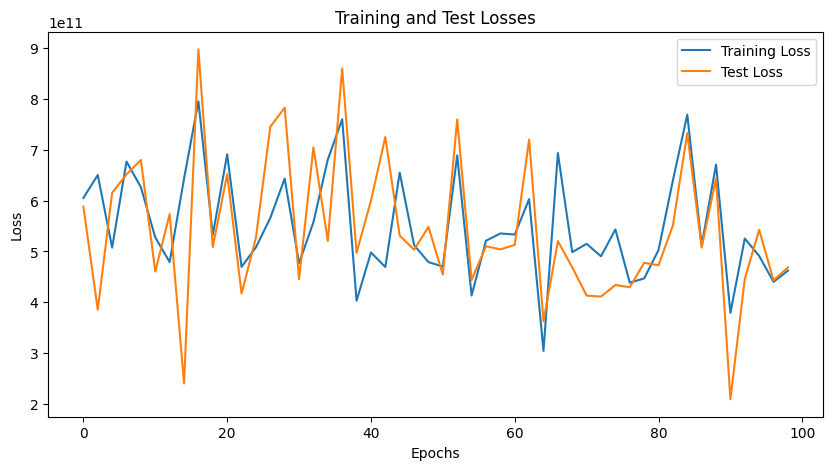

In [185]:
#cubic function
train_model('cubic',input_size=1,hidden_size=12)

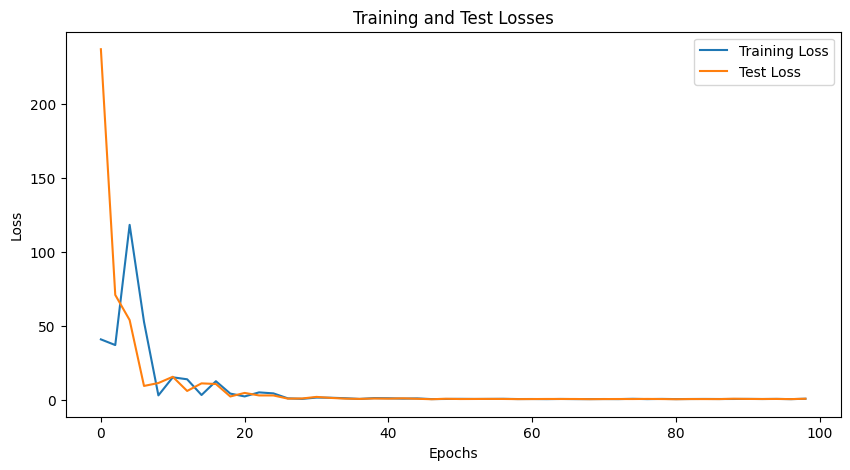

In [186]:
#sin function
train_model('sin',input_size=1,hidden_size=12)


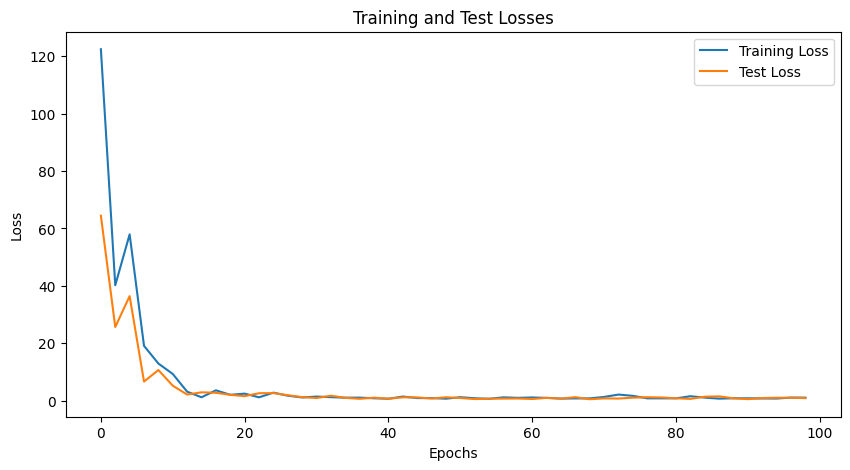

In [151]:
#exponential function
train_model('exp_sin',input_size=1,hidden_size=12)


Epoch 0/100, Train Loss: 3813.498291015625
Test Loss: 670.9378051757812
Epoch 2/100, Train Loss: 799.3768920898438
Test Loss: 882.9761962890625
Epoch 4/100, Train Loss: 646.7322998046875
Test Loss: 351.0677795410156
Epoch 6/100, Train Loss: 138.52166748046875
Test Loss: 102.5685806274414
Epoch 8/100, Train Loss: 191.44248962402344
Test Loss: 279.4800720214844
Epoch 10/100, Train Loss: 375.2292175292969
Test Loss: 291.29412841796875
Epoch 12/100, Train Loss: 164.94113159179688
Test Loss: 69.75450897216797
Epoch 14/100, Train Loss: 28.7890682220459
Test Loss: 61.279197692871094
Epoch 16/100, Train Loss: 108.18102264404297
Test Loss: 117.3027114868164
Epoch 18/100, Train Loss: 135.20016479492188
Test Loss: 89.19891357421875
Epoch 20/100, Train Loss: 52.73175811767578
Test Loss: 13.978235244750977
Epoch 22/100, Train Loss: 23.224124908447266
Test Loss: 46.092838287353516
Epoch 24/100, Train Loss: 72.00520324707031
Test Loss: 75.77376556396484
Epoch 26/100, Train Loss: 45.52458953857422
Tes

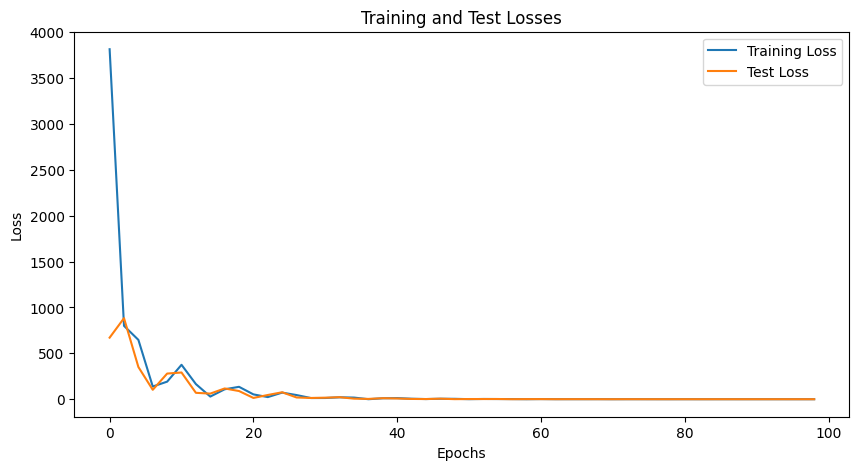

In [126]:
#absolute function
train_model('abs',input_size=1,hidden_units=12)

##Pytorch to build neural networks 2D


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([138])) that is different to the input size (torch.Size([138, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([20])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([134])) that is different to the input size (torch.Size([134, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(in

Epoch 0/100, Train Loss: 3.772082567214966
Test Loss: 2.4015872478485107
Epoch 2/100, Train Loss: 2.8556673526763916
Test Loss: 1.0269964933395386
Epoch 4/100, Train Loss: 1.6089483499526978
Test Loss: 1.8664236068725586
Epoch 6/100, Train Loss: 1.907747507095337
Test Loss: 1.1231023073196411
Epoch 8/100, Train Loss: 1.6543887853622437
Test Loss: 1.7697172164916992
Epoch 10/100, Train Loss: 1.4184895753860474
Test Loss: 1.3311767578125
Epoch 12/100, Train Loss: 1.0650029182434082
Test Loss: 1.5470750331878662
Epoch 14/100, Train Loss: 1.2549747228622437
Test Loss: 1.3163920640945435
Epoch 16/100, Train Loss: 0.9026124477386475
Test Loss: 1.2127892971038818
Epoch 18/100, Train Loss: 1.692026972770691
Test Loss: 1.8759231567382812
Epoch 20/100, Train Loss: 1.264360785484314
Test Loss: 1.1881829500198364
Epoch 22/100, Train Loss: 1.9397441148757935
Test Loss: 1.4834225177764893
Epoch 24/100, Train Loss: 1.2879976034164429
Test Loss: 1.1322888135910034
Epoch 26/100, Train Loss: 1.243099927

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([135])) that is different to the input size (torch.Size([135, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


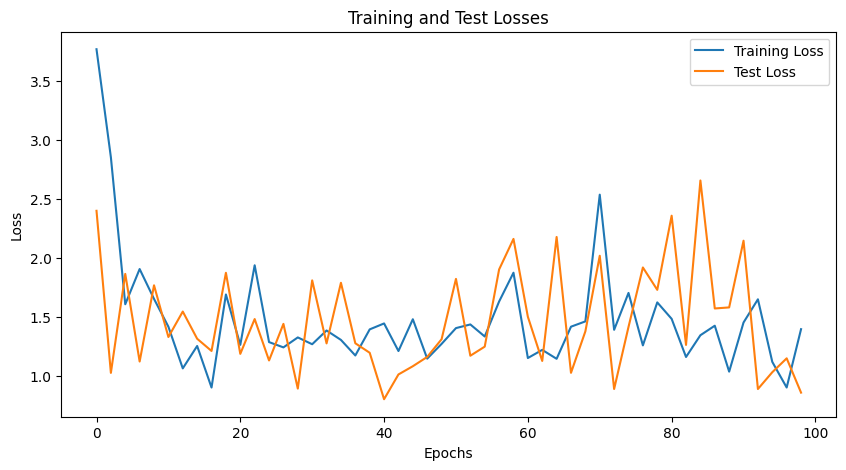

In [137]:
#cubic function
train_model('cubic',input_size=2,hidden_size=12)

Epoch 0/100, Train Loss: 0.3151189982891083
Test Loss: 0.5221050977706909
Epoch 2/100, Train Loss: 0.49995914101600647
Test Loss: 0.5126356482505798
Epoch 4/100, Train Loss: 0.5364689826965332
Test Loss: 0.4138886332511902
Epoch 6/100, Train Loss: 0.48564714193344116
Test Loss: 0.4255453050136566
Epoch 8/100, Train Loss: 0.35622403025627136
Test Loss: 0.4205898642539978
Epoch 10/100, Train Loss: 0.48808109760284424
Test Loss: 0.5128626823425293
Epoch 12/100, Train Loss: 0.4760170876979828
Test Loss: 0.41512253880500793
Epoch 14/100, Train Loss: 0.40117159485816956
Test Loss: 0.47756266593933105
Epoch 16/100, Train Loss: 0.3394378423690796
Test Loss: 0.4106680154800415
Epoch 18/100, Train Loss: 0.3769559860229492
Test Loss: 0.35393211245536804
Epoch 20/100, Train Loss: 0.44420915842056274
Test Loss: 0.43011653423309326
Epoch 22/100, Train Loss: 0.33679309487342834
Test Loss: 0.3528418242931366
Epoch 24/100, Train Loss: 0.34906521439552307
Test Loss: 0.3126225471496582
Epoch 26/100, Trai

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([88])) that is different to the input size (torch.Size([88, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([71])) that is different to the input size (torch.Size([71, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([123])) that is different to the input size (torch.Size([123, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(inpu

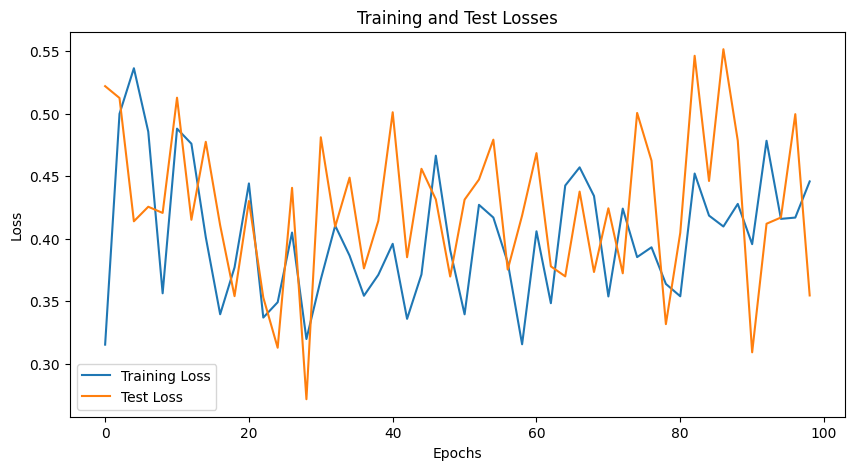

In [138]:
#sin function
train_model('sin',input_size=2,hidden_size=12)

Epoch 0/100, Train Loss: 2.7523114681243896
Test Loss: 2.3063459396362305
Epoch 2/100, Train Loss: 1.505894422531128
Test Loss: 0.6280187964439392
Epoch 4/100, Train Loss: 0.9792053699493408
Test Loss: 0.7662338018417358
Epoch 6/100, Train Loss: 1.0561474561691284
Test Loss: 0.7575018405914307
Epoch 8/100, Train Loss: 0.985891580581665
Test Loss: 1.0928117036819458
Epoch 10/100, Train Loss: 0.9213161468505859
Test Loss: 0.6282022595405579
Epoch 12/100, Train Loss: 1.1229864358901978
Test Loss: 1.785125732421875
Epoch 14/100, Train Loss: 0.8945988416671753
Test Loss: 1.3345035314559937
Epoch 16/100, Train Loss: 0.7995312809944153
Test Loss: 1.2334492206573486
Epoch 18/100, Train Loss: 1.134365439414978
Test Loss: 1.7303340435028076
Epoch 20/100, Train Loss: 1.299597144126892
Test Loss: 1.3976147174835205
Epoch 22/100, Train Loss: 1.0164785385131836
Test Loss: 1.3519370555877686
Epoch 24/100, Train Loss: 1.2130932807922363
Test Loss: 1.8831371068954468
Epoch 26/100, Train Loss: 0.9203367

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([58])) that is different to the input size (torch.Size([58, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([65])) that is different to the input size (torch.Size([65, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([53])) that is different to the input size (torch.Size([53, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input,

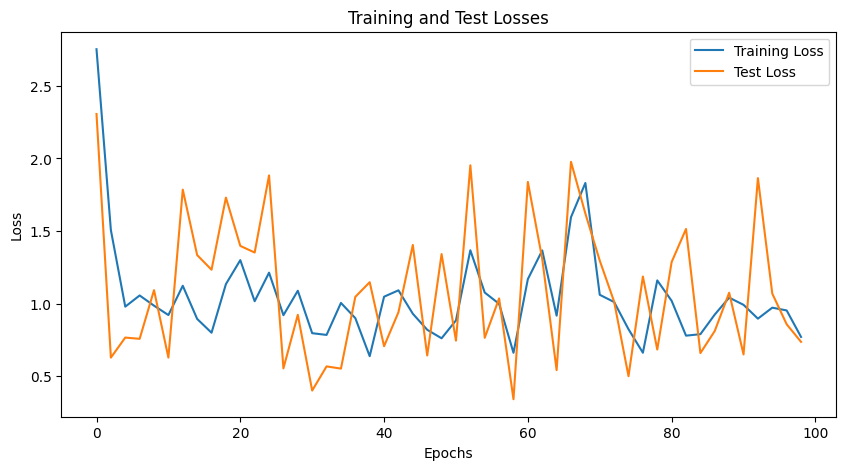

In [139]:
#exponential function
train_model('exp_sin',input_size=2,hidden_size=12)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([76])) that is different to the input size (torch.Size([76, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([20])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([154])) that is different to the input size (torch.Size([154, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(inpu

Epoch 0/100, Train Loss: 1.1407641172409058
Test Loss: 0.46653634309768677
Epoch 2/100, Train Loss: 0.23312601447105408
Test Loss: 0.3312283456325531
Epoch 4/100, Train Loss: 0.30543839931488037
Test Loss: 0.2056976556777954
Epoch 6/100, Train Loss: 0.19786447286605835
Test Loss: 0.14251860976219177
Epoch 8/100, Train Loss: 0.17121796309947968
Test Loss: 0.24703650176525116
Epoch 10/100, Train Loss: 0.24571074545383453
Test Loss: 0.19289018213748932
Epoch 12/100, Train Loss: 0.28582292795181274
Test Loss: 0.21199005842208862
Epoch 14/100, Train Loss: 0.21186427772045135
Test Loss: 0.16404041647911072
Epoch 16/100, Train Loss: 0.117099329829216
Test Loss: 0.15574507415294647
Epoch 18/100, Train Loss: 0.2062145173549652
Test Loss: 0.15091687440872192
Epoch 20/100, Train Loss: 0.1646181344985962
Test Loss: 0.18561695516109467
Epoch 22/100, Train Loss: 0.15719160437583923
Test Loss: 0.13873742520809174
Epoch 24/100, Train Loss: 0.1681065410375595
Test Loss: 0.18746177852153778
Epoch 26/100

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([42])) that is different to the input size (torch.Size([42, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([151])) that is different to the input size (torch.Size([151, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([59])) that is different to the input size (torch.Size([59, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(inpu

Epoch 40/100, Train Loss: 0.1598968803882599
Test Loss: 0.15275540947914124
Epoch 42/100, Train Loss: 0.14148584008216858
Test Loss: 0.17366118729114532
Epoch 44/100, Train Loss: 0.1883048266172409
Test Loss: 0.13296210765838623
Epoch 46/100, Train Loss: 0.18669816851615906
Test Loss: 0.17666484415531158
Epoch 48/100, Train Loss: 0.1836177259683609
Test Loss: 0.10475754737854004
Epoch 50/100, Train Loss: 0.1950465887784958
Test Loss: 0.14438344538211823
Epoch 52/100, Train Loss: 0.14420586824417114
Test Loss: 0.1145387664437294
Epoch 54/100, Train Loss: 0.1488327533006668
Test Loss: 0.16747470200061798
Epoch 56/100, Train Loss: 0.16501659154891968
Test Loss: 0.2018272578716278
Epoch 58/100, Train Loss: 0.14186295866966248
Test Loss: 0.13764049112796783
Epoch 60/100, Train Loss: 0.1674710065126419
Test Loss: 0.2335040420293808
Epoch 62/100, Train Loss: 0.1915658563375473
Test Loss: 0.23495903611183167
Epoch 64/100, Train Loss: 0.18321025371551514
Test Loss: 0.15856456756591797
Epoch 66/

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([63])) that is different to the input size (torch.Size([63, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([107])) that is different to the input size (torch.Size([107, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([137])) that is different to the input size (torch.Size([137, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(in

Epoch 68/100, Train Loss: 0.20332303643226624
Test Loss: 0.18154582381248474
Epoch 70/100, Train Loss: 0.17476046085357666
Test Loss: 0.15012726187705994
Epoch 72/100, Train Loss: 0.17977087199687958
Test Loss: 0.21295665204524994
Epoch 74/100, Train Loss: 0.16435067355632782
Test Loss: 0.1741056889295578
Epoch 76/100, Train Loss: 0.18680912256240845
Test Loss: 0.24101825058460236
Epoch 78/100, Train Loss: 0.24220095574855804
Test Loss: 0.16313865780830383
Epoch 80/100, Train Loss: 0.17281995713710785
Test Loss: 0.17982608079910278
Epoch 82/100, Train Loss: 0.18384963274002075
Test Loss: 0.13539405167102814
Epoch 84/100, Train Loss: 0.16857567429542542
Test Loss: 0.1581350564956665
Epoch 86/100, Train Loss: 0.16178347170352936
Test Loss: 0.19516713917255402
Epoch 88/100, Train Loss: 0.18533694744110107
Test Loss: 0.2139570116996765
Epoch 90/100, Train Loss: 0.19992195069789886
Test Loss: 0.214004784822464
Epoch 92/100, Train Loss: 0.17298521101474762
Test Loss: 0.2137863039970398


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([110])) that is different to the input size (torch.Size([110, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([140])) that is different to the input size (torch.Size([140, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([153])) that is different to the input size (torch.Size([153, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(

Epoch 94/100, Train Loss: 0.1830792874097824
Test Loss: 0.20441605150699615
Epoch 96/100, Train Loss: 0.14828792214393616
Test Loss: 0.13755907118320465
Epoch 98/100, Train Loss: 0.19495469331741333
Test Loss: 0.23684179782867432


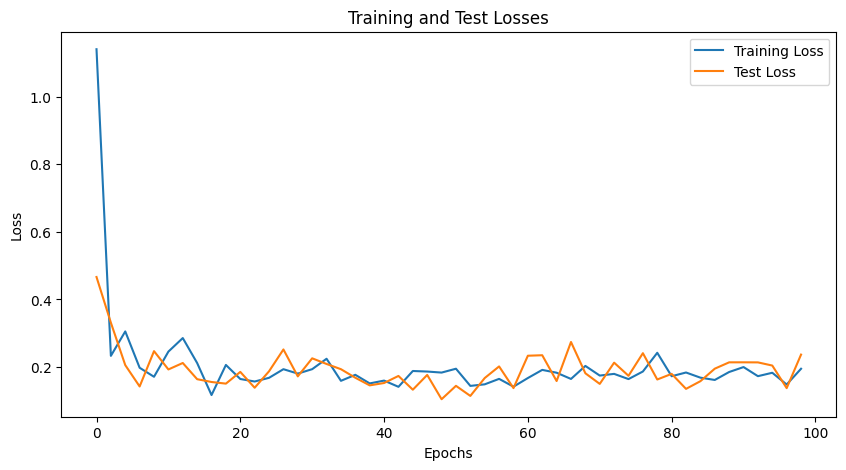

In [141]:
#absolute function
train_model('abs',input_size=2,hidden_size=12)

In [ ]:
# Modules to be loaded and used
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import torch
from torch import nn
import math
from functools import partial
from pathlib import Path
from tqdm import tqdm
import rich
from typing import List, Tuple, Optional, Dict, Any
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import transformers
import tokenizers
import datasets
import zipfile
from huggingface_hub import hf_hub_download

from __future__ import division
from __future__ import print_function

import numpy as np
import deepxde as dde
from deepxde.backend import tf
from scipy.integrate import odeint
import re

import sys
sys.path.append('/content')
import functions

1. a) Polynomial


Compiling model...
Building feed-forward neural network...
'build' took 0.084696 s

'compile' took 2.586962 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [2.05e+11]    [1.52e+11]    [1.00e+00]    
1000      [3.46e+10]    [2.54e+10]    [4.08e-01]    
2000      [3.21e+10]    [2.58e+10]    [4.12e-01]    
3000      [3.16e+10]    [2.55e+10]    [4.09e-01]    
4000      [3.12e+10]    [2.51e+10]    [4.06e-01]    
5000      [3.07e+10]    [2.47e+10]    [4.03e-01]    
6000      [3.00e+10]    [2.41e+10]    [3.98e-01]    
7000      [2.80e+10]    [2.24e+10]    [3.83e-01]    
8000      [1.98e+10]    [1.53e+10]    [3.17e-01]    
9000      [8.96e+09]    [6.51e+09]    [2.07e-01]    
10000     [3.12e+09]    [2.09e+09]    [1.17e-01]    
11000     [9.76e+08]    [6.20e+08]    [6.38e-02]    
12000     [3.08e+08]    [1.97e+08]    [3.60e-02]    
13000     [1.05e+08]    [8.78e+07]    [2.40e-02]    
14000     [4.02e+07]    [4.43e+07]    [1.71e-02]    
15000     [1.41e+07]  

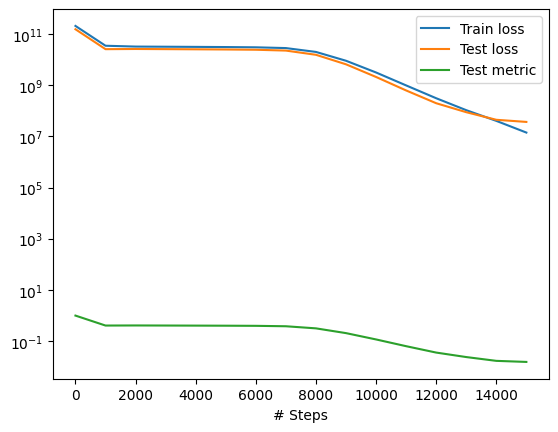

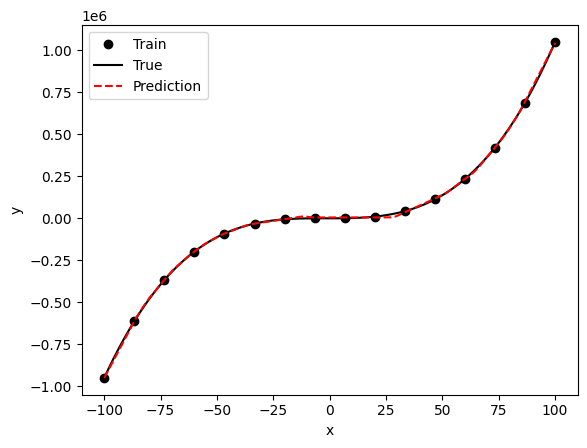

In [ ]:
import deepxde as dde
import numpy as np

a=1
b=5
c=1

geom = dde.geometry.Interval(-100, 100)
num_train = 16
num_test = 100
data = dde.data.Function(geom, lambda x : a*x**3+b*x**2+c*x , num_train, num_test)

activation = "relu"
initializer = "Glorot uniform"
net = dde.nn.FNN([1] + [20] * 3 + [1], activation, initializer)

model = dde.Model(data, net)
model.compile("adam", lr=0.001, metrics=["l2 relative error"])
losshistory, train_state = model.train(iterations=15000)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)

Implementation of an FNN in DeepXDE for a given dataset

Compiling model...
Building feed-forward neural network...
'build' took 0.076844 s



/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.723378 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [5.73e-01]    [4.99e-01]    [1.00e+00]    
1000      [2.88e-02]    [1.01e+00]    [1.42e+00]    
2000      [2.38e-02]    [9.72e-01]    [1.40e+00]    
3000      [9.99e-03]    [9.99e-01]    [1.42e+00]    
4000      [5.16e-04]    [1.02e+00]    [1.43e+00]    
5000      [4.90e-05]    [1.02e+00]    [1.44e+00]    
6000      [9.47e-05]    [1.02e+00]    [1.43e+00]    
7000      [2.13e-05]    [1.02e+00]    [1.43e+00]    
8000      [1.50e-05]    [1.02e+00]    [1.43e+00]    
9000      [8.96e-06]    [1.01e+00]    [1.43e+00]    
10000     [7.89e-06]    [1.01e+00]    [1.43e+00]    

Best model at step 10000:
  train loss: 7.89e-06
  test loss: 1.01e+00
  test metric: [1.43e+00]

'train' took 10.322943 s

Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data to /content/test.dat ...


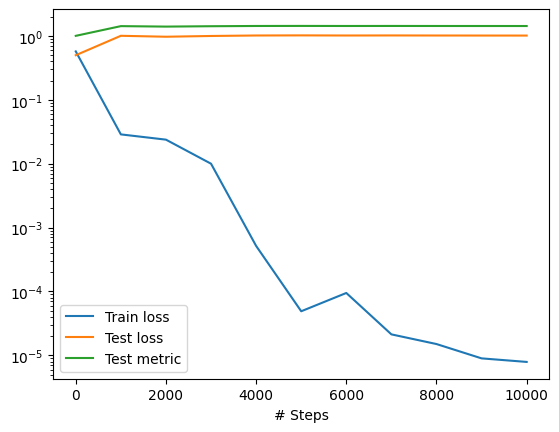

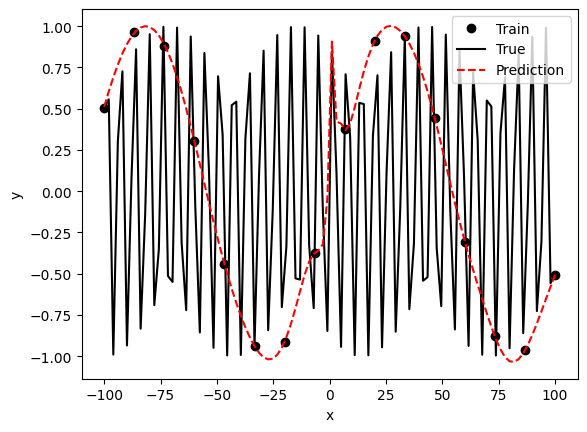

In [ ]:
geom = dde.geometry.Interval(-100, 100)
num_train = 16
num_test = 100
data = dde.data.Function(geom, lambda x: np.sin(x), num_train, num_test)

activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN([1] + [20] * 3 + [1], activation, initializer)

model = dde.Model(data, net)
model.compile("adam", lr=0.001, metrics=["l2 relative error"])
losshistory, train_state = model.train(iterations=10000)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)

Compiling model...
Building feed-forward neural network...
'build' took 0.086467 s



/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.745739 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [3.38e+03]    [3.40e+03]    [1.00e+00]    
1000      [1.30e+03]    [1.32e+03]    [6.23e-01]    
2000      [6.15e+02]    [6.25e+02]    [4.29e-01]    
3000      [2.80e+02]    [2.86e+02]    [2.90e-01]    
4000      [1.19e+02]    [1.22e+02]    [1.90e-01]    
5000      [4.62e+01]    [4.82e+01]    [1.19e-01]    
6000      [1.63e+01]    [1.73e+01]    [7.14e-02]    
7000      [5.26e+00]    [5.73e+00]    [4.11e-02]    
8000      [1.57e+00]    [1.78e+00]    [2.29e-02]    
9000      [4.63e-01]    [5.49e-01]    [1.27e-02]    
10000     [1.49e-01]    [1.84e-01]    [7.35e-03]    

Best model at step 10000:
  train loss: 1.49e-01
  test loss: 1.84e-01
  test metric: [7.35e-03]

'train' took 11.980773 s

Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data to /content/test.dat ...


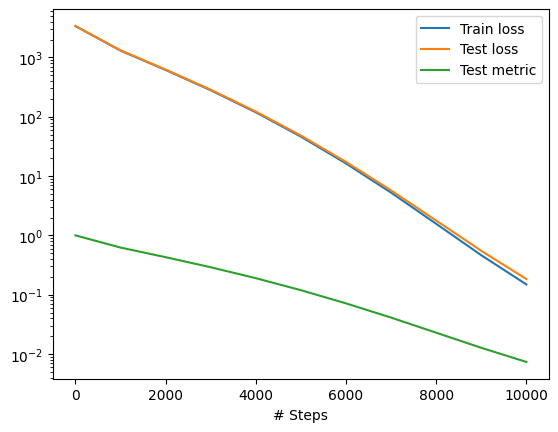

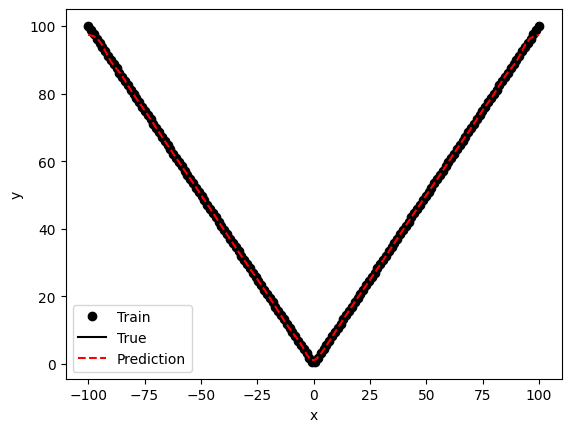

In [ ]:
import deepxde as dde
import numpy as np

geom = dde.geometry.Interval(-100, 100)
num_train = 160
num_test = 100
data = dde.data.Function(geom, lambda x: abs(x) , num_train, num_test)

activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN([1] + [20] * 3 + [1], activation, initializer)

model = dde.Model(data, net)
model.compile("adam", lr=0.001, metrics=["l2 relative error"])
losshistory, train_state = model.train(iterations=10000)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)

In [ ]:
geom = dde.geometry.Interval(-10, 10)
num_train = 16
num_test = 100
data = dde.data.Function(geom, lambda x: np.exp(x) , num_train, num_test)

activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN([2] + [20] * 3 + [1], activation, initializer)

model = dde.Model(data, net)
model.compile("adam", lr=0.001, metrics=["l2 relative error"])
losshistory, train_state = model.train(iterations=10000)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)

Compiling model...
Building feed-forward neural network...
'build' took 0.117982 s



/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 2.624651 s

Training model...



AttributeError: ignored

In [ ]:
geom = dde.geometry.Rectangle(xmin=[0,0],xmax=[2,2])
num_train = 16
num_test = 100
data = dde.data.Function(geom, lambda x, y : x * y , num_train, num_test)

activation = "relu"
initializer = "Glorot uniform"
net = dde.nn.FNN([2] + [20] * 3 + [1], activation, initializer)

model = dde.Model(data, net)
model.compile("adam", lr=0.001, metrics=["l2 relative error"])
losshistory, train_state = model.train(iterations=5000)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)

Compiling model...
Building feed-forward neural network...
'build' took 0.074445 s

'compile' took 2.498599 s

Training model...



TypeError: ignored